### Metropolis Hastings

In [79]:
import torch
dist = torch.distributions
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [80]:
mix = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(torch.tensor([0.2, 0.8])),
    component_distribution=dist.Normal(torch.tensor([0.1, 3]), torch.tensor([0.6, 3])),
)

In [81]:
x = torch.linspace(-4., 4, 5)

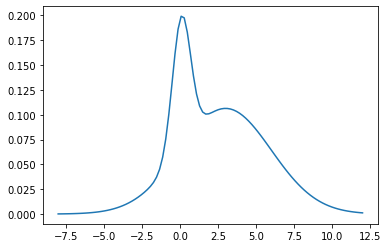

In [82]:
theta_range = torch.linspace(-8, 12, 100)
plt.plot(theta_range, mix.log_prob(theta_range).exp())

In [83]:
mix.mean, mix.stddev

(tensor(2.4200), tensor(2.9356))

In [84]:
next_sample = lambda cur_sample: dist.Normal(loc = cur_sample, scale=1).sample().item()

In [85]:
next_sample(1)

2.0207135677337646

In [86]:
p = lambda x: mix.log_prob(torch.tensor(x)).exp().item()
lp = lambda x: mix.log_prob(torch.tensor(x)).item()

In [87]:
p(2)

0.10151920467615128

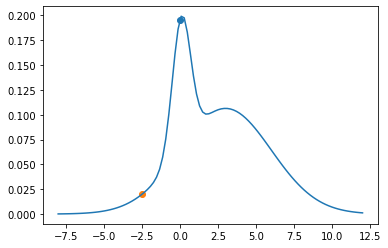

In [88]:
num_iter = 10
xs = [None]*num_iter
xs[0] = 0.
plt.plot(theta_range, mix.log_prob(theta_range).exp())
plt.scatter(xs[0], p(xs[0]))

xs[1] = next_sample(xs[0])
plt.scatter(xs[1], p(xs[1]))



0.27602488498335154

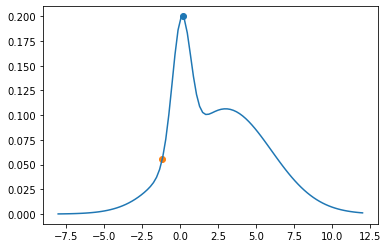

In [89]:
num_iter = 10
xs = [None]*num_iter
xs[0] = 0.2
plt.plot(theta_range, mix.log_prob(theta_range).exp())
plt.scatter(xs[0], p(xs[0]))

xs[1] = next_sample(xs[0])
plt.scatter(xs[1], p(xs[1]))

a = p(xs[1])/p(xs[0])
a

In [90]:
u = dist.Uniform(0, 1).sample().item()
print(u)

0.049220144748687744


In [91]:
if u < a:
    xs[1] = xs[0]

In [92]:
x_start = 0.
num_iter = 20000
xs = torch.empty(num_iter)
xs[0] = x_start
lu = torch.log(dist.Uniform(0, 1).sample([num_iter]))
for i in range(1, num_iter):
    xs[i] = next_sample(xs[i-1])
   
    la = lp(xs[i]) - lp(xs[i-1])

    if lu[i] > la:
        xs[i] = xs[i-1]
    
    

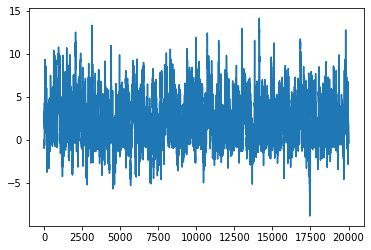

In [93]:
plt.plot(xs)

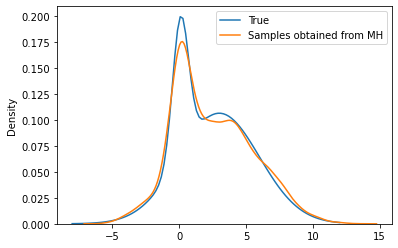

In [94]:
import seaborn as sns

plt.plot(theta_range, mix.log_prob(theta_range).exp(), label='True')
sns.kdeplot(torch.tensor(xs[:10000]), label='Samples obtained from MH')
plt.legend()


In [95]:
xs[:1000].mean(), mix.mean,  xs[:1000].std(), mix.stddev

(tensor(3.5472), tensor(2.4200), tensor(3.0889), tensor(2.9356))

In [96]:
import numpy as np

In [97]:
g = emcee.moves.GaussianMove(cov = 1.)

In [98]:
import emcee

nwalkers = 2
ndim = 1
log_prob = lp
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob,moves=g)
state = sampler.run_mcmc(p0, 100)
sampler.reset()
sampler.run_mcmc(state, 10000, progress=True);


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3105.40it/s]


In [99]:
samples = sampler.get_chain(flat=True)

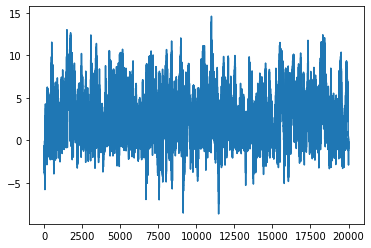

In [100]:
plt.plot(samples)

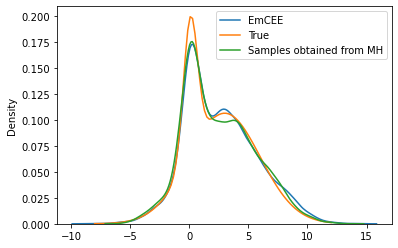

In [101]:
sns.kdeplot(samples.flatten(), label='EmCEE')

plt.plot(theta_range, mix.log_prob(theta_range).exp(), label='True')
sns.kdeplot(torch.tensor(xs[:10000]), label='Samples obtained from MH')
plt.legend()

### Creating a function

In [102]:
def mh(log_p, next_sample, num_iter, x_start):
    lu = torch.log(dist.Uniform(0, 1).sample([num_iter]))
    try: 
        l = len(x_start)
        xs = torch.empty((num_iter, len(x_start)))
    except:
        xs = torch.empty(num_iter)
    xs[0] = x_start
    
    for i in range(1, num_iter):
        xs[i] = next_sample(xs[i-1])

        la = log_p(xs[i]) - log_p(xs[i-1])

        if lu[i] > la:
            xs[i] = xs[i-1]
    return xs

In [105]:
xs = mh(lp, next_sample, 10000, 0.)

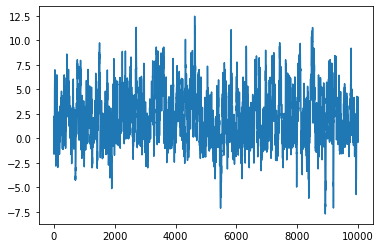

In [106]:
plt.plot(xs)

### 2d 

In [107]:
dist_2d = dist.MultivariateNormal(loc = torch.zeros(2), covariance_matrix=torch.tensor([[1., 0.5], [0.5, 2.]]))
dist_2d

MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))

In [109]:
log_p_2d = lambda x: dist_2d.log_prob(torch.tensor(x)).item()
next_sample_2d = lambda cur_sample: dist.MultivariateNormal(
    loc=cur_sample, covariance_matrix=torch.eye(len(cur_sample))
).sample()

In [149]:
x_2d = mh(log_p_2d, next_sample_2d, 5000, torch.tensor([0., 0.]))

<AxesSubplot:>

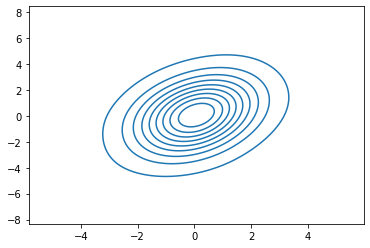

In [150]:
sns.kdeplot(x_2d[:, 0], x_2d[:, 1], bw_adjust=4)

In [151]:
import corner

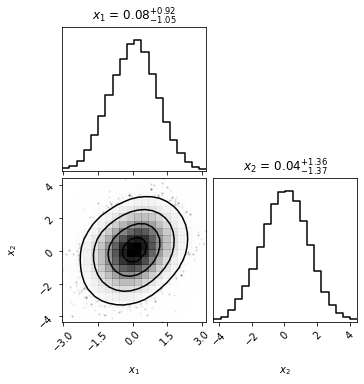

In [155]:
corner.corner(x_2d.numpy(), smooth=2, show_titles=True, labels=[r"$x_1$", "$x_2$"], smooth1d=1, );

### Linear Regression with 1 parameter

In [112]:
y = 4*x + 0.5*torch.randn(5)
prior = dist.Normal(loc = 0., scale = 1.)
log_likelihood = lambda t: dist.Normal(loc = x*t, scale=1.).log_prob(y).sum(axis=0)
unnorm_post = lambda t:log_likelihood(torch.tensor(t)).item() - prior.log_prob(torch.tensor(t)).item()

In [115]:
xs = mh(unnorm_post, next_sample, 10000, 0.)

<AxesSubplot:ylabel='Density'>

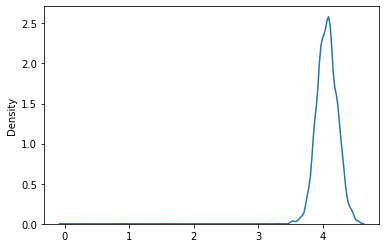

In [123]:
sns.kdeplot(xs)

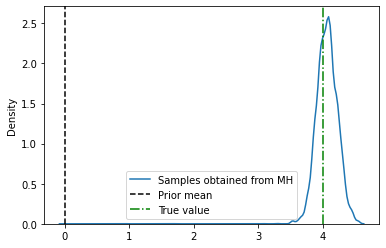

In [126]:
import seaborn as sns

sns.kdeplot(xs.numpy(), label='Samples obtained from MH')
plt.axvline(0., label='Prior mean', color='k', linestyle='--')
plt.axvline(4, label='True value', color='g', linestyle='-.')
plt.legend()

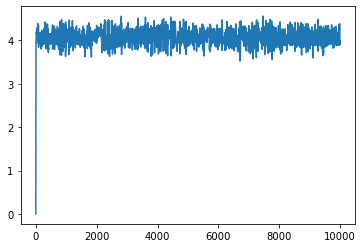

In [127]:
plt.plot(xs)

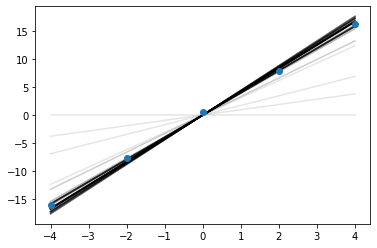

In [128]:
for i in range(100):
    plt.plot(x, xs[i]*x, alpha=0.1, color='k')
plt.scatter(x, y, zorder=10)

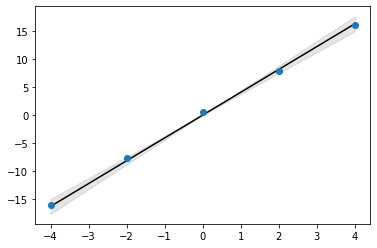

In [130]:
xs_mean = xs.mean()
xs_std = xs.std()

plt.plot(x, xs_mean*x, color='k')
plt.scatter(x, y, zorder=10)
plt.fill_between(x, (xs_mean-2*xs_std)*x, (xs_mean+2*xs_std)*x, color='k', alpha=0.1)


### Linear Regression with 2 parameter

In [132]:
y = 4*x + 0.5*torch.randn(5)
prior = dist.MultivariateNormal(loc = torch.zeros([2]), covariance_matrix=torch.eye(2))
log_likelihood = lambda t: dist.Normal(loc = x*t[1] + t[0], scale=1.).log_prob(y).sum(axis=0)
unnorm_post = lambda t:log_likelihood(torch.tensor(t)).item() - prior.log_prob(torch.tensor(t)).item()

References

1. https://www.youtube.com/watch?v=yCv2N7wGDCw
